---
title: Implementing Logistic Regression
author: Sophie Seiple
date: '2024-04-8'
image: "logistic.jpg"
description: "Implementing and testing the logistic regression algorithm."
format: html
---

Link to my [logistic regression implementation.](https://github.com/esseiple/esseiple.github.io/blob/main/posts/logistic/logistic.py)

## Abstract

In this blog post, I implement logistic regression, a fundamental algorithm of of machine learning, and perform experiments to explore the accuracy and behavior of my implementation. I implement vanilla gradient descent, and a variant of gradient descent known as gradient descent with momentum, aimed at achieving faster convergence. I conduct experiments and create visualizations to validate my implementation, examining the behavior of vanilla gradient descent versus gradient descent with momentum and addressing the phenomenon of overfitting. Through experimentation and analysis, I gained insights into the behavior and performance of logistic regression models under various conditions, as well as best practices when using the algorithm to make predictions.

In [1]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

## Vanilla Gradient Descent

The first experiment I performed was implementing vanilla gradient descent using my model. This form of gradient descent involves ignoring beta as a paramater (setting it to 0), and instead only using alpha as a learning parameter. With these parameters and 2-dimensional data I hoped to observe a monotonous decrease in loss over time, eventually, over 1000 iterations, becoming very small, which would show that our model is learning and becoming better at separating our data.

I used the classification_data function from the blog post description to create an instance of 2-D data for our model.

In [2]:
import torch

def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y


# DO NOT RE-RUN

X, y = classification_data(noise = 0.5)

Below I plotted the data in order to visualize the separation.

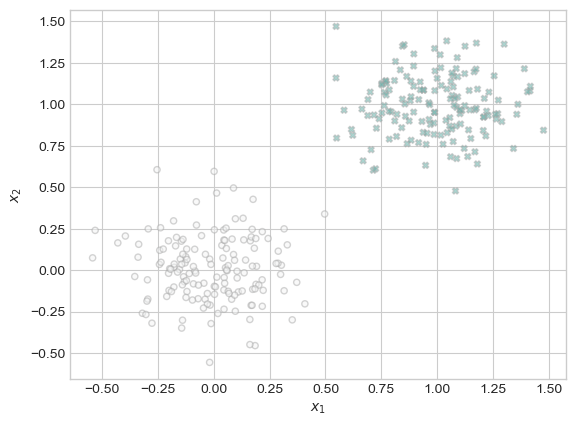

<Figure size 1000x600 with 0 Axes>

In [3]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# adapted from perceptron blog post
def plot_classification_data(X, y, ax):
    plt.figure(figsize=(10, 6))
    targets = [0, 1]
    markers = ["o" , "X"]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    
    
fig, ax = plt.subplots(1, 1)

# create and plot data
X, y = classification_data(noise = 0.2)
plot_classification_data(X, y, ax)

Next, I created a logistic regression instance, and ran a 6000 iteration training loop over my generated data. I chose 6000 after experimenting to see when the line began to level out and make slower progress.

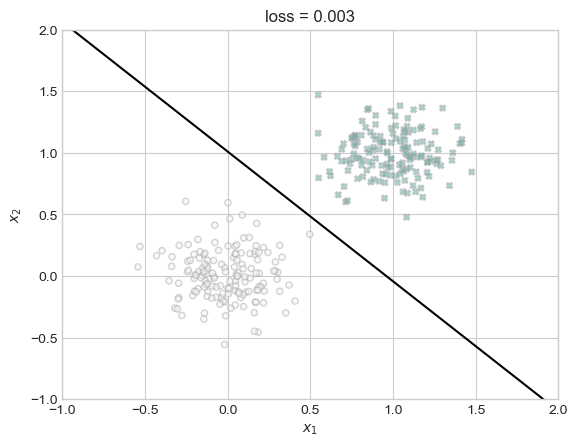

<Figure size 1000x600 with 0 Axes>

In [4]:
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

loss_vec = []

# store each iterations loss in a vector, update weights each time for 1000 times
for _ in range(6000):
    loss = LR.loss(X, y)
    loss_vec.append(loss)
    opt.step(X, y, a = 0.6, b=0)


# taken from the perceptron blog post
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)


fig, ax = plt.subplots(1, 1)


# plot data
plot_classification_data(X, y, ax)

# plot best dividing line
draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-1, 2), ylim=(-1, 2));

As we can see, the line our model found does a very good job of estimating the divide between our two data groups. Our final loss was around 0.003. Next, I plotted the change  in our loss over time using our loss vector.

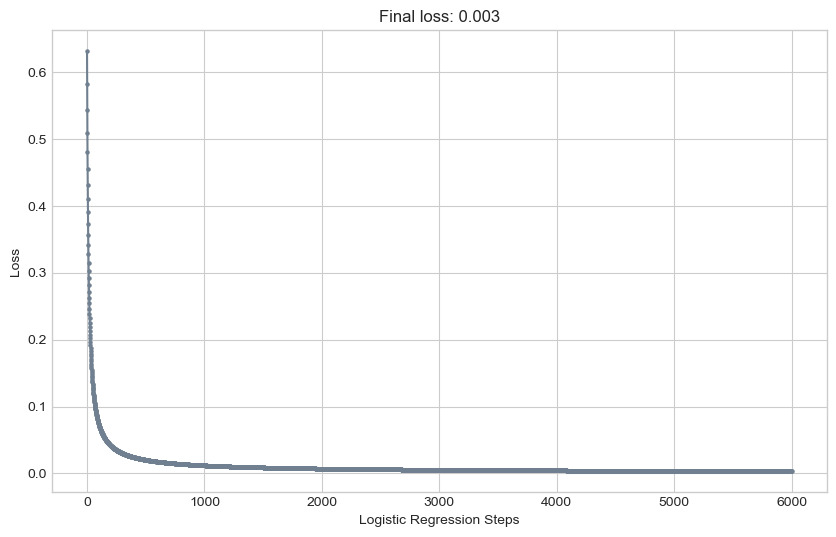

In [5]:
# taken from perceptron blog post, plots loss over iterations
def plot_loss(lvec):
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(10, 6))

    
    plt.plot(lvec, color = "slategrey")
    plt.scatter(torch.arange(len(lvec)), lvec, color = "slategrey", s=5)
    plt.gca().set(xlabel = "Logistic Regression Steps", ylabel = "Loss")
    
    plt.title(f"Final loss: {lvec[len(lvec)-1]:.3f}")

plot_loss(loss_vec);

We see that the loss changes as we would hope, in that it does in fact decrease with our iterations, and starts to converge at low numbers as our iterations increase.

## Benefits of Momentum

The next experiment I performed was to use a non-zero beta value to explore momentum. What we expect to see is our model converging faster (in fewer iterations) to the same or smaller loss values. I chose 3000 iterations as I wanted to see how few iterations I could run the model for in order to acheive the same result as our first model.

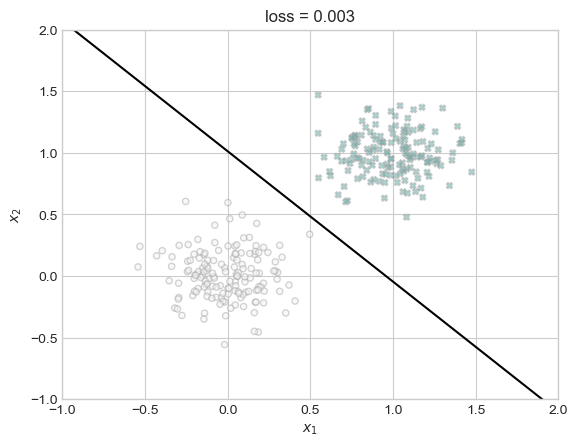

<Figure size 1000x600 with 0 Axes>

In [6]:
LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

loss_vec_m = []

# a = 0.06, b = 0.05
# took some experimentation because values too high caused loss to become so small it wouldn't format as a number
for _ in range(3000):
    loss = LR.loss(X, y)
    loss_vec_m.append(loss)
    opt.step(X, y, a = 0.6, b=0.5)

# plot data and loss
fig, ax = plt.subplots(1, 1)

plot_classification_data(X, y, ax)

draw_line(LR.w, x_min=-1, x_max=2, ax=ax, color="black")
ax.set_title(f"loss = {loss:.3f}")
ax.set(xlim=(-1, 2), ylim=(-1, 2));

We see here that we do in fact end with the same loss value in 3000 iterations that our training without momentum found in 6000 iterations. Next, I plotted the loss over iterations of the model with momentum over the loss over iterations of our vanilla model to see whether the loss decreased faster than the vanilla gradient descent loss.

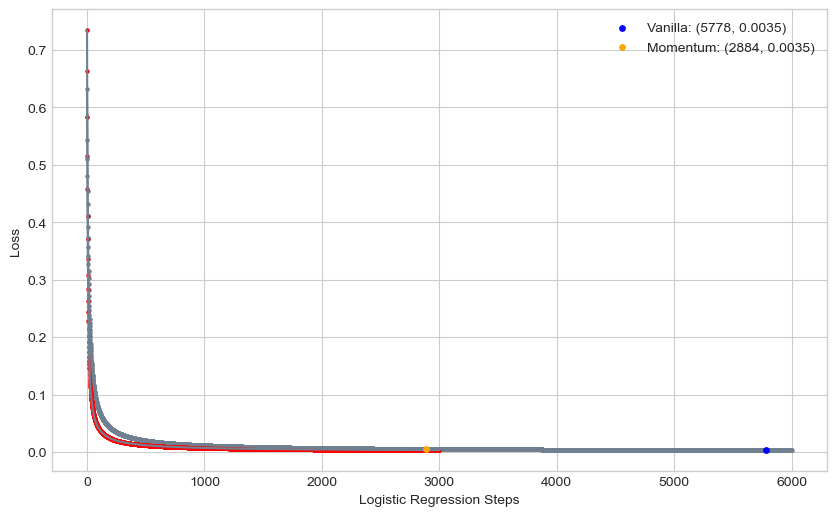

In [7]:
import numpy as np

plt.figure(figsize=(10,6))

# plotting vanilla
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey", s=5)
plt.gca().set(xlabel = "Logistic Regression Steps", ylabel = "Loss")

# plotting with momentum
plt.plot(loss_vec_m, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec_m)), loss_vec_m, color = "red", s=5)
plt.gca().set(xlabel = "Logistic Regression Steps", ylabel = "Loss");

# plotting points where y = 0.0035
plt.scatter(5778, loss_vec[5777].item(), color="blue", label=f'Vanilla: ({5778}, {0.0035})', s=15, zorder=3)
plt.scatter(2884, loss_vec[2883].item(), color="orange", label=f'Momentum: ({2884}, {0.0035})', s=15, zorder=3)

plt.legend()


plt.show()


In this graph, the red line shows the model trained with momentum, and the grey line shows the vanilla model. It's clear that the red line is moving towards convergence at or around zero faster than the grey line. As we saw in the model training, both models were able to reach a final (rounded) loss of 0.003 in the given iterations. In order to visualize the difference in speeds between the two models, I plotted where each model first reached a value $\approx$ 0.0035 (my cut off was anything less than 0.0036, which would then feasibly be rounded down to 0.003), these points are shown in orange and blue. We can see that the red line, the orange dot, reached 0.0035 in 2,884 iterations, while the grey line (the blue dot) took almost double the iterations to reach the same loss, 5,778. I decided to stop the momentum line in fewer iterations than the vanilla model also partly because of visualizations issues, as the lines start to look indistinguishable at very small values, but I found that 3000 iterations was enough to show the steeper initial slope of the momentum model, and to show the earlier appearance of the value our vanilla model settled on in a larger number of iterations.

## Overfitting

The next experiment I performed was to examine the effects of overfitting our model on training and testing data. I created two sets of data, one training and one testing, both with 100 dimensions (features) and 50 data points. This creates a dataset with many more features than actual instances, which is very susceptible to overfitting.

In [225]:
X_train,y_train = classification_data(n_points = 50, noise = 0.2, p_dims = 100)
X_test,y_test = classification_data(n_points = 50, noise = 0.2, p_dims = 100)

I trained the model on our training data with varying alpha, beta values until I found a training accuracy of 100%. I looped my training process untill I reached a loss of at most 0.005, which to me was close enough to zero to be considered fully trained.

In [253]:
from sklearn.metrics import accuracy_score

LR = LogisticRegression()
opt = GradientDescentOptimizer(LR)

loss_vec = []
loss = 1.0

# train model
while loss > 0.005:
    loss = LR.loss(X_train, y_train)
    loss_vec.append(loss)
    opt.step(X_train, y_train, a = 0.06, b=0.9)

# generate predictions
y_train_pred = LR.predict(X_train)
# calculate training accuracy using scikitlearn function
train_acc = accuracy_score( y_train.numpy(), y_train_pred.numpy())
print(train_acc)

1.0


To visualize the complete training of our model, I also plotted the loss over iterations.

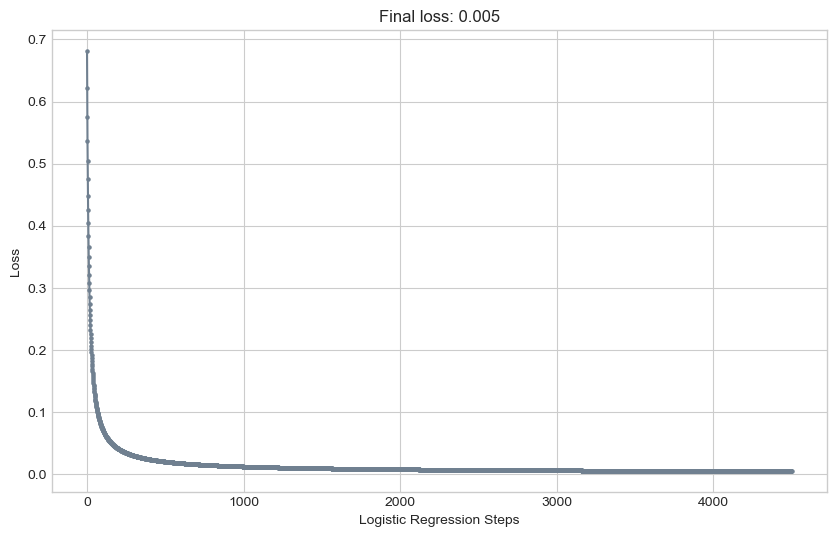

In [270]:
import math
cleaned_list = [x for x in loss_vec if not math.isnan(x)]
plot_loss(cleaned_list)

Then I used the trained model to generate predictions and accuracy for our testing data.

In [254]:
# generate predictions
y_test_pred = LR.predict(X_test)
# calculate testing accuracy using scikitlearn function
accuracy_test = accuracy_score(y_test.numpy(), y_test_pred.numpy())
print(accuracy_test)

0.96


As we can see, despite acheiving 100% accuracy on our training data, we can only acheive 96% accuracy on our testing data, speaking to the drawbacks of overfitting a model to training instances.

## Discussion

These experiments on my implementation of logistic regression revealed intriguing insights into the behavior and performance of logistic regression models trained using gradient descent with/without momentum, and into overfitting with logistic regression. Firstly, my findings demonstrated that gradient descent with momentum outperforms vanilla gradient descent in terms of convergence speed. By incorporating momentum, the optimization process exhibits faster convergence towards an optimal solution (smaller loss). This observation underscores the effectiveness of momentum as a tool for logistic regression models. The experiments also shed light on the phenomenon of overfitting in logistic regression models. When the number of dimensions exceeds the number of data points, logistic regression models are susceptible to overfitting, as demonstrated by the attainment of 100% accuracy on the training data while achieving less optimal performance on testing data. This highlights the importance of model evaluation strategies to mitigate the risk of overfitting and ensure the generalization ability of the trained model. Overall, by understanding the nuances of optimization techniques and model behavior, I feel more able to make informed decisions that enhance the performance and robustness of logistic regression models for various classification tasks.